In [23]:
import sys
sys.path.insert(0, '../src/models')

In [1]:
%reload_ext watermark
%watermark -uniz --author "Prayson W. Daniel" -vm -p pandas,numpy,matplotlib,scikit-learn,lemmy,dill

Prayson W. Daniel 
last updated: Fri May 29 2020 DST 2020-05-29T12:50:15+02:00

CPython 3.7.6
IPython 7.14.0

pandas 1.0.3
numpy 1.18.4
matplotlib 3.1.3
sklearn 0.23.1
lemmy 2.1.0
dill 0.3.1.1

compiler   : GCC 7.3.0
system     : Linux
release    : 4.4.0-17763-Microsoft
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [24]:
import joblib
import re
import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegressionCV
import lemmy


from helpers import show_diagram, show_most_informative_features

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight')

In [9]:
PATH_TO_DATA = '../src/data'
STOP_WORDS = joblib.load(f'{PATH_TO_DATA}/stops.pkl')

In [10]:
lemmatizer = lemmy.load('da')

def tokenizer(blob, stop_words=STOP_WORDS, remove_digits=True):
    
    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    # 14år --> 14 år
    text = re.sub(r'([0-9]+(\.[0-9]+)?)', r' \1 ', text).strip()
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    text_nostop = [word for word in text.split() if word not in stop_words]
    
    # tokenization lemmatize
    lemmatized_text = [lemmatizer.lemmatize('', word)[-1]  
                                 for word in text_nostop]
    
    remove_stopwords = ' '.join(word for word in lemmatized_text if len(word)>1)
    
    if remove_digits:
        remove_stopwords = re.sub(r'\b\d+\b', '', remove_stopwords)
    

    # remove extra spaces
    remove_stopwords = ' '.join(remove_stopwords .split())
    result = f'{remove_stopwords} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [11]:
tokenizer('Jeg er vred på, at jeg ikke fik min pakke :(')

['vred', 'ikke', ':(']

In [12]:
df = pd.read_json(f'{PATH_TO_DATA}/data.json')

In [22]:
df.shape

(254464, 3)

In [13]:
 X_train, X_test, y_train, y_test = train_test_split(df['features'], 
                                                     df['target'],
                                                     test_size=.2,
                                                     random_state=7,
                                                     stratify=df['target'])

In [14]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')
print(f'\nTraing Size\n\tPositive||Negative Samples\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')
print(f'\nTest Size\n\tPositive||Negative Samples\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Traing Size: 203571
Test Size:    50893

Traing Size
	Positive||Negative Samples
	  101785||101786

Test Size
	Positive||Negative Samples
	  25447||25446


In [15]:
hisia = Pipeline(steps =[
        ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                 max_features=100000,
                                 tokenizer=tokenizer, 
                                 #stop_words=STOP_WORDS
                                )
        ),
        ('feature_selector', SelectKBest(chi2, k=5000)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('logistic_regression', LogisticRegressionCV(cv=5,
                                                    solver='saga',
                                                    scoring='accuracy',
                                                    n_jobs=-1, 
                                                    verbose=0))
])

In [16]:
%%time
hisia.fit(X_train, y_train)

/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/pwd/miniconda3/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model

CPU times: user 6min 11s, sys: 2.97 s, total: 6min 14s
Wall time: 1min 57s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=100000, ngram_range=(1, 2),
                                 tokenizer=<function tokenizer at 0x7fb3adcfa050>)),
                ('feature_selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7fb3b076b5f0>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('logistic_regression',
                 LogisticRegressionCV(cv=5, n_jobs=-1, scoring='accuracy',
                                      solver='saga'))])

In [17]:
hisia.score(X_test, y_test)

0.9364352661466213

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.94     25446
    Positive       0.94      0.93      0.94     25447

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




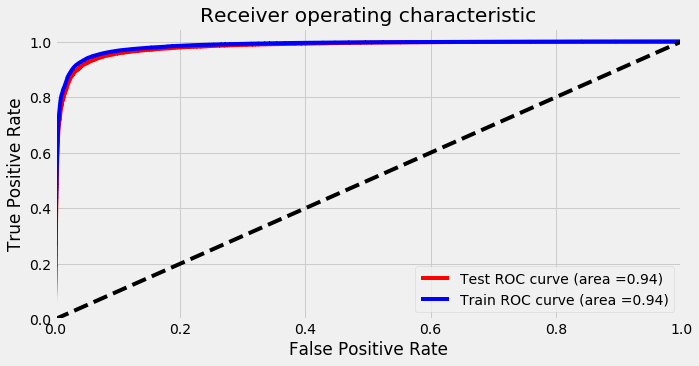

In [18]:
show_diagram(hisia, X_train, y_train, X_test, y_test, compare_test=True)

In [19]:
feature_names = hisia.named_steps['count_verctorizer'].get_feature_names()
best_features = [feature_names[i] for i in hisia.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia.named_steps['logistic_regression']

In [20]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-9.4246	dårlig         		7.7718	super          
	-8.7937	ikke orden     		7.5769	perfekt        
	-8.4744	uacceptabel    		7.4488	god            
	-7.9517	elendig        		7.0411	hurtig         
	-6.7636	kilometer      		6.9701	:-)            
	-6.2875	ikke god       		6.9019	nem            
	-6.0995	ommer          		6.5670	dejlig         
	-6.0491	ikke iorden    		6.2889	fin            
	-5.9278	ikke anbefale  		6.1522	fremragende    
	-5.9138	ikke modtage   		6.0947	tilfreds       
	-5.6820	opsige         		6.0687	sætte finger   
	-5.6685	øv             		5.9166	hurtigt        
	-5.5796	ingen hjælpe   		5.7746	fantastisk     
	-5.4783	ikke tilfreds  		5.6395	:)             
	-5.4253	latterlig      		5.4770	ingen problem  
	-5.4076	smadre         		5.2711	ingen klage    
	-5.3187	nægte          		5.2019	varm anbefale  
	-5.2504	langsom       

In [21]:
def persist_model(name,clf=None, method='load'):
    'Pass in the file name, object to be saved or loaded'
    
    if method == 'load':
        with open(name,'rb') as f:
            return dill.load(f)
    elif method == 'save':
        print(f'[+] Persisting {name} ...')
        if clf is None:
            raise ValueError('Pass Model/Pipeline/Transformation')
        with open(name,'wb') as f:
            dill.dump(clf,f)
            print(f'[+] Persistence Complete. Model {name} is saved')
    else:
        raise ValeuError('Wrong arguments')

In [61]:
persist_model('base_model.pkl', clf=hisia, method='save')

[+] Persisting base_model.pkl ...
[+] Persistence Complete. Model base_model.pkl is saved


In [26]:
hisia.predict(['Jeg er vred på, at jeg ikke fik min pakke :('])

array([0])

In [28]:
res = hisia.predict_proba(['Jeg er vred på, at jeg ikke fik min pakke :('])

In [32]:
df = pd.DataFrame(res)

In [36]:
df['sentiment'] = np.where(df[0] > .5, 'negative', 'positive')

,0,1,sentiment
0,0.968012,0.031988,negative


In [48]:
df.columns = ['negative_probability','positive_probability','sentiment']

In [38]:
from collections import namedtuple

In [39]:
Sentiment = namedtuple('Sentiment', ['sentiment','positive_probability', 'negative_probability'])

In [41]:
df

,negative,positive,sentiment
0,0.968012,0.031988,negative


In [52]:
for _, item in df.to_dict(orient='index').values():
    k = Sentiment(**item)

In [65]:
b = Sentiment(**df.round(3).to_dict(orient='index')[0])

In [69]:
type(b)

__main__.Sentiment

In [72]:
b

Sentiment(sentiment='negative', positive_probability=0.032, negative_probability=0.968)